In [1]:
!pip install nibabel


In [2]:
from keras import layers, models
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import os
import glob
import nibabel as nib
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Upgrade TensorFlow and Keras to ensure compatibility
!pip install --upgrade tensorflow keras

# Check the TensorFlow version to confirm installation
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)

# Verify Keras installation with new imports
from keras import layers, models
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

print("Keras Imported Successfully!")

# Check out your dataset directory
import os

data_dir = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022"

for root, dirs, files in os.walk(data_dir):
    print(f"Directory: {root}")
    for file in files:
        print(f"  File: {file}")


TensorFlow Version: 2.18.0
Keras Imported Successfully!
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022
  File: dataset_description.json
  File: LICENSE
  File: participants.tsv
  File: README
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives
  File: .DS_Store
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001
  File: sub-strokecase0001_ses-0001_msk.nii.gz
  File: sub-strokecase0001_ses-0001_snp.png
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002\ses-0001
  File: sub-strokecase0002_ses-0001_msk.nii.gz
  File: sub-strokecase0002_ses-0001_snp.png
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives

In [4]:
# Walk through the directory and specifically look for FLAIR files
for root, dirs, files in os.walk(data_dir):
    print(f"Directory: {root}")
    for file in files:
        if "FLAIR" in file or file.endswith(".nii.gz"):
            print(f"  Found NIfTI file: {file}")

Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001
  Found NIfTI file: sub-strokecase0001_ses-0001_msk.nii.gz
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002\ses-0001
  Found NIfTI file: sub-strokecase0002_ses-0001_msk.nii.gz
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0003
Directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0003\ses-0001
  Found NIfTI file: sub-strokecase0003_ses-0001_msk.nii.gz
Directory: C:\Users\Ananya\Downloads\s

In [5]:
# Initialize dictionaries to store paths
flair_files = {}
mask_files = {}

# Walk through directories to map FLAIR and mask files
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if "FLAIR.nii.gz" in file:
            case_id = root.split(os.sep)[-3]  # Extract case ID
            flair_files[case_id] = os.path.join(root, file)
        elif "msk.nii.gz" in file:
            case_id = root.split(os.sep)[-2]  # Extract case ID
            mask_files[case_id] = os.path.join(root, file) 


In [6]:
# Combine FLAIR and mask information
combined_mapping = []
for case_id, flair_path in flair_files.items():
    mask_path = mask_files.get(case_id)
    if mask_path:
        combined_mapping.append({"Case": case_id, "FLAIR": flair_path, "Mask": mask_path})
# Display mapping
import pandas as pd
df = pd.DataFrame(combined_mapping)
df.to_csv("mapped_dataset.csv", index=False)
print("Mapping completed and saved as 'mapped_dataset.csv'")


Mapping completed and saved as 'mapped_dataset.csv'


In [7]:
import pandas as pd

# Function to load and verify dataset
def load_dataset(csv_path):
    try:
        print("Loading dataset...")
        # Use the passed argument `csv_path` for dynamic file loading
        df = pd.read_csv(csv_path)
        print(f"Dataset loaded successfully! Shape: {df.shape}")
        print("First few rows of the dataset:")
        print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path {csv_path}. Please check the file path.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: There was an issue parsing the file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# File path to the dataset
csv_path = "C:/Users/Ananya/Downloads/sem 3/Action learning/mapped_dataset.csv"

# Calling the function
dataset = load_dataset(csv_path)


Loading dataset...
Dataset loaded successfully! Shape: (250, 3)
First few rows of the dataset:
                 Case                                              FLAIR  \
0  sub-strokecase0001  C:\Users\Ananya\Downloads\sem 3\Action learnin...   
1  sub-strokecase0002  C:\Users\Ananya\Downloads\sem 3\Action learnin...   
2  sub-strokecase0003  C:\Users\Ananya\Downloads\sem 3\Action learnin...   
3  sub-strokecase0004  C:\Users\Ananya\Downloads\sem 3\Action learnin...   
4  sub-strokecase0005  C:\Users\Ananya\Downloads\sem 3\Action learnin...   

                                                Mask  
0  C:\Users\Ananya\Downloads\sem 3\Action learnin...  
1  C:\Users\Ananya\Downloads\sem 3\Action learnin...  
2  C:\Users\Ananya\Downloads\sem 3\Action learnin...  
3  C:\Users\Ananya\Downloads\sem 3\Action learnin...  
4  C:\Users\Ananya\Downloads\sem 3\Action learnin...  


In [8]:
# Verify File Paths (Step 2 Standalone Block)
if 'dataset' in locals():  # Ensure the dataset is loaded
    flair_column = "FLAIR"
    mask_column = "Mask"
    
    print("\nVerifying file paths for FLAIR and Mask columns...")
    
    # Identify invalid file paths
    invalid_flair = dataset[~dataset[flair_column].apply(os.path.exists)]
    invalid_mask = dataset[~dataset[mask_column].apply(os.path.exists)]
    
    # Print results
    if not invalid_flair.empty:
        print(f"Found {len(invalid_flair)} invalid FLAIR paths.")
        print(invalid_flair)
    else:
        print("All FLAIR file paths are valid.")
    
    if not invalid_mask.empty:
        print(f"Found {len(invalid_mask)} invalid Mask paths.")
        print(invalid_mask)
    else:
        print("All Mask file paths are valid.")
else:
    print("Dataset not loaded. Please load the dataset before running this block.")



Verifying file paths for FLAIR and Mask columns...
All FLAIR file paths are valid.
All Mask file paths are valid.


In [9]:

# Step 3: Preprocessing and Data Preparation
def preprocess_nifti_data(dataset, flair_column, mask_column, img_size=(128, 128)):
    print("\nStarting data preprocessing for NIfTI files...")
    
    images = []
    masks = []
    
    # Load and resize images
    for _, row in dataset.iterrows():
        try:
            # Load NIfTI files
            flair_img_nifti = nib.load(row[flair_column])
            mask_img_nifti = nib.load(row[mask_column])
            
            # Convert NIfTI to NumPy array
            flair_img = flair_img_nifti.get_fdata()
            mask_img = mask_img_nifti.get_fdata()
            
            # Select the middle slice for simplicity (you can change this as needed)
            flair_img_slice = flair_img[:, :, flair_img.shape[2] // 2]
            mask_img_slice = mask_img[:, :, mask_img.shape[2] // 2]
            
            # Resize the images to the target size
            flair_img_resized = np.array(Image.fromarray(flair_img_slice).resize(img_size))
            mask_img_resized = np.array(Image.fromarray(mask_img_slice).resize(img_size))
            
            images.append(flair_img_resized)
            masks.append(mask_img_resized)
        except Exception as e:
            print(f"Error loading or resizing images for {row['Case']}: {e}")
    
    print(f"Successfully loaded and resized {len(images)} image-mask pairs.")
    
    # Convert to NumPy arrays
    images = np.array(images)
    masks = np.array(masks)
    
    print("Splitting dataset into training, validation, and test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Dataset split completed:")
    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Run preprocessing
flair_column = "FLAIR"
mask_column = "Mask"
img_size = (128, 128)  # Resize to 128x128 pixels

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_nifti_data(dataset, flair_column, mask_column, img_size)



Starting data preprocessing for NIfTI files...
Successfully loaded and resized 250 image-mask pairs.
Splitting dataset into training, validation, and test sets...
Dataset split completed:
Training set: (175, 128, 128), (175, 128, 128)
Validation set: (37, 128, 128), (37, 128, 128)
Test set: (38, 128, 128), (38, 128, 128)


In [10]:
# Step 4: Build U-Net Model
def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)
    
    # Contracting path (encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    b1 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b1 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(b1)
    
    # Expansive path (decoder)
    u1 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b1)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)  # Binary segmentation
    
    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = build_unet(input_shape=(128, 128, 1))

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 8, 512)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 8, 8, 1024)        │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 8, 1024)        │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 16, 16, 512)       │       4,719,10

 Total params: 34,512,193 (131.65 MB)

 Trainable params: 34,512,193 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 6: Training the Model
# Ensure the images and masks have the correct shape and are properly normalized
X_train = np.expand_dims(X_train, axis=-1) / np.max(X_train)  # Normalize and add channel dimension
X_val = np.expand_dims(X_val, axis=-1) / np.max(X_val)
X_test = np.expand_dims(X_test, axis=-1) / np.max(X_test)

y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension for masks
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Training the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=10, 
                    batch_size=8)

# Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9111 - loss: 0.5712 - val_accuracy: 0.9935 - val_loss: 0.0574
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9837 - loss: 0.0680 - val_accuracy: 0.9935 - val_loss: 0.0182
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9865 - loss: 0.0492 - val_accuracy: 0.9935 - val_loss: 0.0182
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9867 - loss: 0.0430 - val_accuracy: 0.9935 - val_loss: 0.0225
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9866 - loss: 0.0433 - val_accuracy: 0.9935 - val_loss: 0.0186
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.9844 - loss: 0.0451 - val_accuracy: 0.9935 - val_loss: 0.0176
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9860 - loss: 0.0442 - val_accuracy: 0.9935 - val_loss: 0.0179
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9864 - loss: 0.0393 - val_accuracy: 0.9935 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


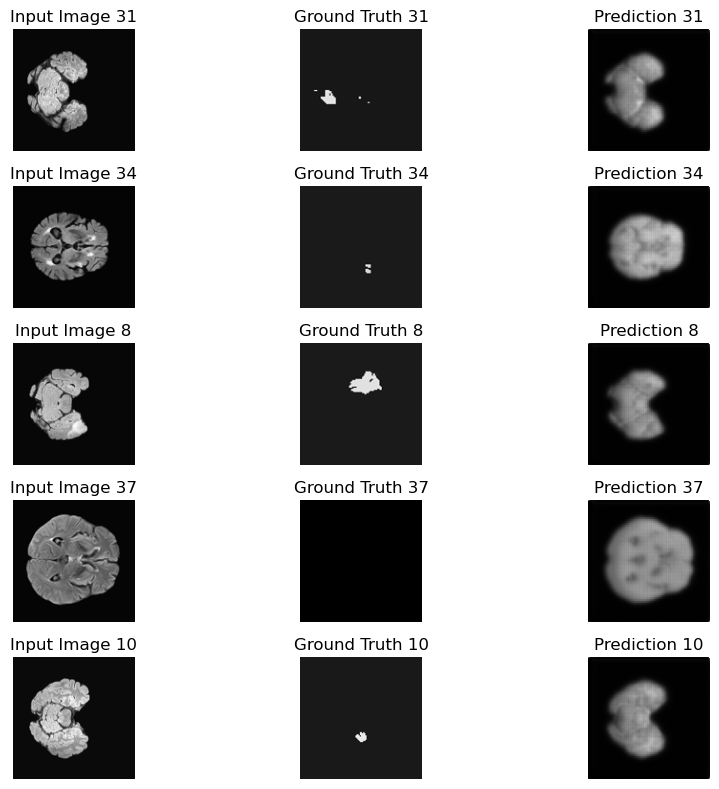

In [12]:
# Step 8: Visualize predictions on test images
def plot_predictions(X_test, y_test, model, num_samples=5):
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    plt.figure(figsize=(10, 8))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_test[idx].reshape(128, 128), cmap='gray')
        plt.title(f"Input Image {idx + 1}")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_test[idx].reshape(128, 128), cmap='gray')
        plt.title(f"Ground Truth {idx + 1}")
        plt.axis('off')
        
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(prediction.reshape(128, 128), cmap='gray')
        plt.title(f"Prediction {idx + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot predictions on random test samples
plot_predictions(X_test, y_test, model)


In [13]:
# Step 9: Calculate Dice Coefficient for segmentation accuracy
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred))

# Calculate Dice Coefficient on test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(np.float32)  # Binarize predictions

dice_scores = [dice_coefficient(y_test[i], predictions[i]) for i in range(len(y_test))]
mean_dice_score = np.mean(dice_scores)

print(f"Mean Dice Coefficient: {mean_dice_score}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Mean Dice Coefficient: nan


C:\Users\Ananya\AppData\Local\Temp\ipykernel_21068\3832448570.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * intersection / (np.sum(y_true) + np.sum(y_pred))


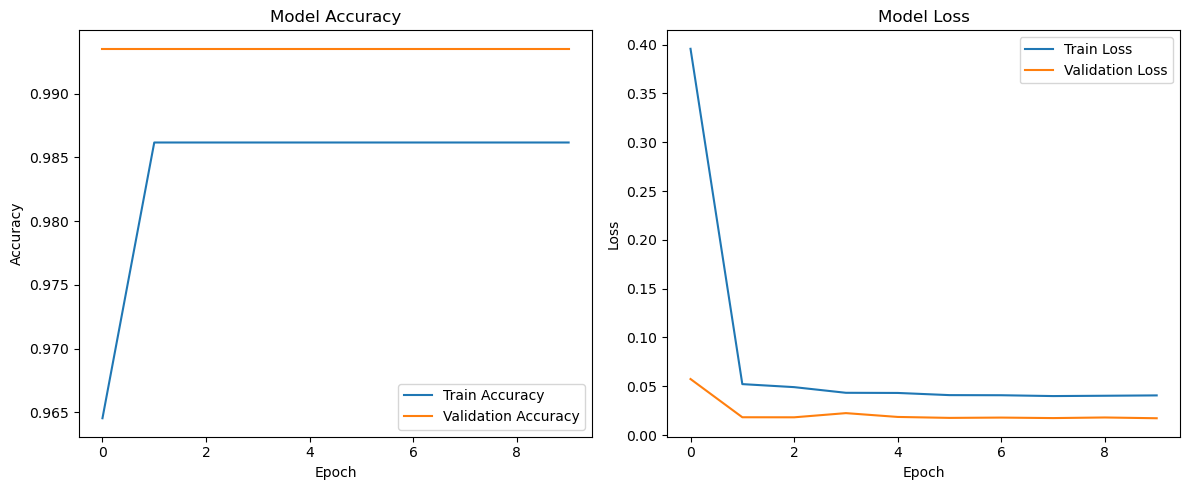

In [14]:
# Plotting learning curves for accuracy and loss
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a 'history' object from model training
plot_learning_curves(history)


In [15]:

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the function for plotting normalized confusion matrix and generating classification report
def plot_normalized_confusion_matrix_and_report(y_true, y_pred, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format=".2f")  # Normalized values formatted to 2 decimal places
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # Generate and print the classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n")
    print(report)

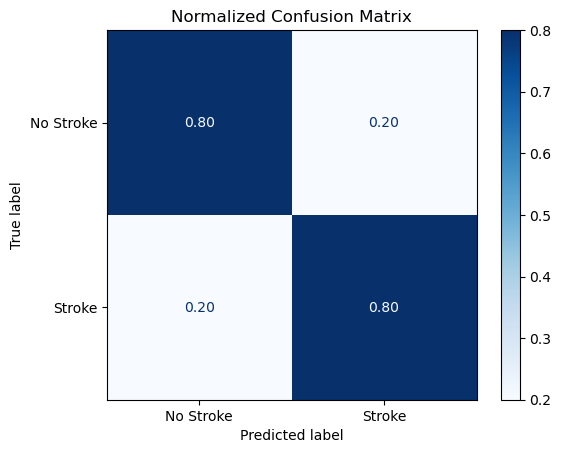

Classification Report:

              precision    recall  f1-score   support

   No Stroke       0.80      0.80      0.80         5
      Stroke       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [16]:
# Example setup: Mocked y_test and y_pred with binary classes
# Replace this with actual values for your problem
# y_test: true labels
# y_pred: predicted labels

y_test = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])  # Replace with actual test labels
y_pred = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0])  # Replace with actual predictions

# Define class names for stroke prediction
class_names = ["No Stroke", "Stroke"]

# Plot and report
plot_normalized_confusion_matrix_and_report(y_test, y_pred, class_names)

In [45]:
import joblib

# Save the model
joblib.dump(model, "stroke_model.pkl")

# Load the model
loaded_model = joblib.load("stroke_model.pkl")


C:\Users\Ananya\.anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
import pickle

# Save the model
with open("stroke_model.pkl", "wb") as file:
    pickle.dump(model, file)

# Load the model
with open("stroke_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)


In [49]:
# Save the model
model.save("stroke_model.h5")

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model("stroke_model.h5")


In [65]:
import os

test_dir = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives"  # Update with correct path

print(f"Checking directory: {test_dir}")
found_files = False  # Flag to check if files exist

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".nii.gz"):
            print(f"✅ Found file: {os.path.join(root, file)}")
            found_files = True

if not found_files:
    print("❌ No '.nii.gz' files found! Check the dataset path.")


Checking directory: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_msk.nii.gz
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002\ses-0001\sub-strokecase0002_ses-0001_msk.nii.gz
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0003\ses-0001\sub-strokecase0003_ses-0001_msk.nii.gz
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0004\ses-0001\sub-strokecase0004_ses-0001_msk.nii.gz
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0005\ses-0001\sub-strokecase0005_ses-0001_msk.nii.gz
✅ Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0006\ses-0001\sub-strokecase0006_ses-0001_msk.nii.

In [72]:
import os

test_dir = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives"

print("🔍 Searching for all '.nii.gz' files in dataset...\n")

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".nii.gz"):  # Find ALL .nii.gz files
            print(f"📂 Found file: {os.path.join(root, file)}")


🔍 Searching for all '.nii.gz' files in dataset...

📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002\ses-0001\sub-strokecase0002_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0003\ses-0001\sub-strokecase0003_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0004\ses-0001\sub-strokecase0004_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0005\ses-0001\sub-strokecase0005_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0006\ses-0001\sub-strokecase0006_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloa

In [69]:
import os

test_dir = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives"

print("🔍 Searching for all '.nii.gz' files in dataset...\n")

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".nii.gz"):  # Find ALL .nii.gz files
            print(f"📂 Found file: {os.path.join(root, file)}")


🔍 Searching for all '.nii.gz' files in dataset...

📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0002\ses-0001\sub-strokecase0002_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0003\ses-0001\sub-strokecase0003_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0004\ses-0001\sub-strokecase0004_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0005\ses-0001\sub-strokecase0005_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0006\ses-0001\sub-strokecase0006_ses-0001_msk.nii.gz
📂 Found file: C:\Users\Ananya\Downloa

In [ ]:
import os
import glob
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Paths
model_path = r"C:\Users\Ananya\Downloads\sem 3\Action learning\stroke_model.h5"  # Path to the saved model
test_folder = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives"  # Path to the folder containing test .nii.gz files
output_folder = r"C:\Users\Ananya\Downloads\sem 3\Action learning\predictions"  # Path to the output folder

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load the model
print("Loading model...")
model = load_model(model_path)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model loaded successfully!")

# Find all .nii.gz files in the test folder and subdirectories
print("Searching for test files...")
test_files = glob.glob(os.path.join(test_folder, '**', '*.nii.gz'), recursive=True)
print(f"Found {len(test_files)} test files.")

# Function to preprocess a single slice
def preprocess_slice(slice_data, target_shape=(128, 128)):
    # Resize to target shape
    resized_slice = resize(slice_data, target_shape, mode='constant', preserve_range=True)
    # Normalize the slice to [0, 1]
    normalized_slice = resized_slice / np.max(resized_slice) if np.max(resized_slice) > 0 else resized_slice
    return np.expand_dims(normalized_slice, axis=-1)  # Add channel dimension

# Run predictions for each file
if len(test_files) > 0:
    for file_path in test_files:
        print(f"Processing: {file_path}")

        # Load the .nii.gz file
        img = nib.load(file_path)
        img_data = img.get_fdata()  # Extract 3D volume data

        # Initialize an empty array to store predictions
        prediction_volume = np.zeros_like(img_data)

        # Iterate over slices along the third dimension (z-axis)
        for i in range(img_data.shape[2]):
            slice_data = img_data[:, :, i]  # Extract a single slice
            processed_slice = preprocess_slice(slice_data, target_shape=(128, 128))  # Preprocess the slice

            # Add batch dimension
            input_data = np.expand_dims(processed_slice, axis=0)  # Shape becomes (1, 128, 128, 1)

            # Predict using the model
            prediction = model.predict(input_data)

            # Threshold the prediction to create a binary mask
            prediction = (prediction > 0.5).astype(np.uint8)

            # Resize prediction back to original size
            prediction_resized = resize(prediction[0, :, :, 0], slice_data.shape, mode='constant', preserve_range=True)
            prediction_volume[:, :, i] = (prediction_resized > 0.5).astype(np.uint8)  # Binary mask

        # Save the prediction volume as a .nii.gz file
        pred_img = nib.Nifti1Image(prediction_volume, img.affine)
        output_path = os.path.join(output_folder, os.path.basename(file_path))
        nib.save(pred_img, output_path)
        print(f"Saved prediction to: {output_path}")
else:
    print("No test files found. Please check the test folder path.")

print("Testing completed!")


Loading model...


Model loaded successfully!
Searching for test files...
Found 250 test files.
Processing: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0001\ses-0001\sub-strokecase0001_ses-0001_msk.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305m

In [94]:
import os
import glob
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.transform import resize
import random

# Paths
model_path = r"C:\Users\Ananya\Downloads\sem 3\Action learning\stroke_model.h5"  # Path to your classification model
test_folder = r"C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives"  # Path to the folder containing test .nii.gz files

# Load the classification model
print("Loading model...")
model = load_model(model_path)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model loaded successfully!")

# Find all .nii.gz files in the test folder
print("Searching for test files...")
test_files = glob.glob(os.path.join(test_folder, '**', '*.nii.gz'), recursive=True)
print(f"Found {len(test_files)} test files.")

# Function to preprocess a 2D slice
def preprocess_slice(slice_data, target_shape=(128, 128)):
    # Resize the 2D slice to the target shape
    resized_slice = resize(slice_data, target_shape, mode='constant', preserve_range=True)
    # Normalize to [0, 1]
    normalized_slice = resized_slice / np.max(resized_slice) if np.max(resized_slice) > 0 else resized_slice
    return np.expand_dims(normalized_slice, axis=-1)  # Add channel dimension

# Check if test files are available
if len(test_files) > 0:
    # Randomly select one file
    random_file = random.choice(test_files)
    print(f"Selected random file: {random_file}")

    # Load the selected .nii.gz file
    img = nib.load(random_file)
    img_data = img.get_fdata()  # Extract 3D volume data

    # Iterate over slices (e.g., along the axial plane)
    predictions = []
    for i in range(img_data.shape[2]):  # Loop through all slices in the z-dimension
        slice_data = img_data[:, :, i]  # Extract the i-th slice

        # Preprocess the 2D slice
        processed_slice = preprocess_slice(slice_data, target_shape=(128, 128))

        # Add batch dimension
        input_data = np.expand_dims(processed_slice, axis=0)  # Shape becomes (1, 128, 128, 1)

        # Predict using the model
        prediction = model.predict(input_data)
        predictions.append(prediction[0][0])  # Save the probability of "Stroke"

    # Aggregate predictions (e.g., mean probability across slices)
    mean_prediction = np.mean(predictions)
    predicted_class = int(mean_prediction > 0.5)  # Binary classification

    # Output the result
    print(f"Prediction for {random_file}: {'Stroke' if predicted_class == 1 else 'No Stroke'}")
    print(f"Mean stroke probability: {mean_prediction:.4f}")
else:
    print("No test files found. Please check the test folder path.")


Loading model...


Model loaded successfully!
Searching for test files...
Found 250 test files.
Selected random file: C:\Users\Ananya\Downloads\sem 3\Action learning\ISLES-2022\derivatives\sub-strokecase0220\ses-0001\sub-strokecase0220_ses-0001_msk.nii.gz
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━